<a href="https://colab.research.google.com/github/chirenshah/TweetClassifier/blob/master/KAGGLE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REQUISITES
****
**DEPENDENCIES**

Importing the necessary Libraries 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,accuracy_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**DATASET ACQUISITION**

Downloading the required Csv files using the Kaggle API

In [0]:
!mkdir .kaggle  #Making a .kaggle folder

In [0]:
### Creating a file with our Credentials for the Kaggle API

import json
token = {"username":"XXXXXX","key":"XXXXXXXXX"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json #Copy the Credentials to .kaggle folder
!chmod 600 /root/.kaggle/kaggle.json  #Change Permissions for the Credentials file 
!kaggle config set -n path -v{/content} #Setting up download path for the Kaggle API

- path is now set to: {/content}


In [0]:
!kaggle competitions download -c nlp-getting-started # Downloading the Competitions Dataset

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 40.4MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 56.6MB/s]


In [0]:
train = pd.read_csv('/content/{/content}/competitions/nlp-getting-started/train.csv')
test = pd.read_csv('/content/{/content}/competitions/nlp-getting-started/test.csv')
submission = pd.read_csv('/content/{/content}/competitions/nlp-getting-started/sample_submission.csv')

# DATA FAMILIARIZATION
****
Familiarizing ourselves with the Distribution of dataset contents

##Disaster and Non Disaster Tweets Distribution 

Comparing distribution of Disaster and Non Disaster Tweets

Text(0, 0.5, 'Count')

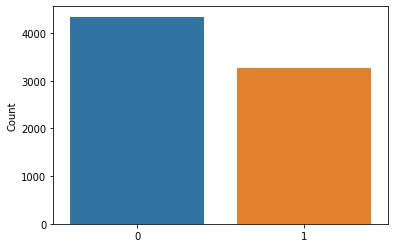

In [0]:
x=train.target.value_counts()
fig = sns.barplot(x.index,x)
fig.set_ylabel('Count')


##Frequency Distribution of Characters
Plotting the frequency distribution of Characters in Disaster and Non-Disaster Tweets

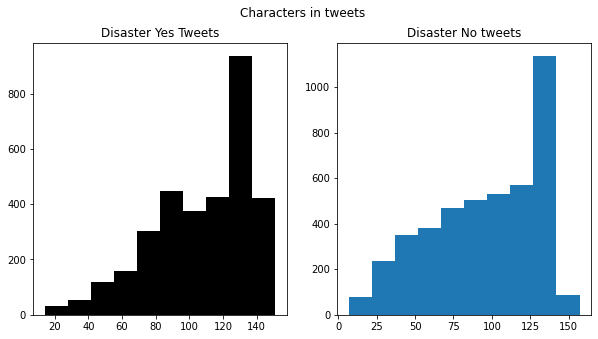

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len , color='black')
ax1.set_title('Disaster Yes Tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len)
ax2.set_title('Disaster No tweets')
fig.suptitle('Characters in tweets')
plt.show()

##Keyword Distribution

Comparing distribution of Disaster and Non Disaster Tweets

Text(0.5, 1.0, '')

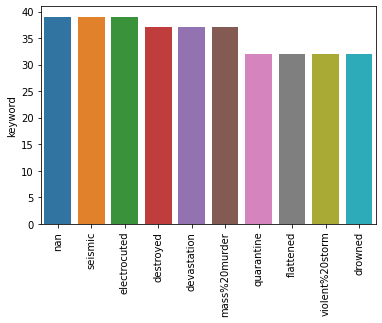

In [0]:
x=train[train['target']==1]['keyword'].value_counts()
x = x.sort_values(ascending=False)
fig = sns.barplot(x.index[:10],x[:10])
fig.set_xticklabels(list(set(train['keyword'])),rotation=90)
fig.set_title("")


Text(0.5, 1.0, '')

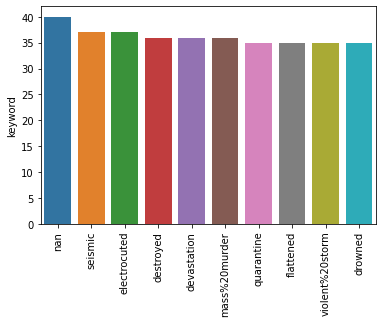

In [0]:
x=train[train['target']==0]['keyword'].value_counts()
x = x.sort_values(ascending=False)
fig = sns.barplot(x.index[:10],x[:10])
fig.set_xticklabels(list(set(train['keyword'])),rotation=90)
fig.set_title("")

# DATA PREPROCESSING
****
In this section the dataset is preProcessed to remove Characters and Stopwords from the Tweets 

In [0]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [0]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text
train['text'] = train['text'].apply(lambda x: text_preprocessing(x))
test['text'] = test['text'].apply(lambda x: text_preprocessing(x))

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [0]:
test['text'] = test['text'].apply(lambda x: clean_text(x))
test['text']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety fasten...
3259    storm ri worse last hurricane hardest hit yard...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [0]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [0]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [0]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [0]:
#print(train_tfidf)

# SUBMISSION
****
**MODEL SELECTION**

Selecting the appropriate model for data prediction

**REGRESSION MODELS**

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
scores = model_selection.cross_val_score(model, train_tfidf, train["target"], cv=5, scoring="accuracy")
scores.mean()

0.6889563702596111

In [0]:
from sklearn.linear_model import RidgeClassifier
RC = RidgeClassifier()
scores = model_selection.cross_val_score(RC, train_tfidf, train["target"], cv=5, scoring="accuracy")
scores.mean()

0.6626870681094009

**MULTINOMIAL NAVIE BAYES**

In [0]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="accuracy")
scores.mean()

0.7207485226526592

**TIME SERIES MODEL**

In [0]:





from sklearn import model_selection


import csv
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

from sklearn import preprocessing
from numpy import asarray
from numpy import zeros
from keras.layers import Flatten
from numpy import array




2.2.0-rc2


In [0]:
vocab_size = 5000
embedding_dim = 64
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

tweets = []
labels = []

for index, row in train.iterrows():
  labels.append(str(row[4]))
  article = row[3]
  for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
  tweets.append(article)
        
   
print(len(labels))
print(len(tweets))
train_size = int(len(tweets) * training_portion)

train_articles = tweets[0: train_size]
train_labels = labels[0: train_size]

validation_articles = tweets[train_size:]
validation_labels = labels[train_size:]

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
dict(list(word_index.items())[0:10])

7613
7613


{'<OOV>': 1,
 'amp': 3,
 'body': 9,
 'emergency': 8,
 'i': 2,
 'like': 4,
 'new': 6,
 'people': 7,
 'the': 5,
 'video': 10}

In [0]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)
print(set(labels))


1523
(1523, 50)
{'1', '0'}


In [0]:

embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	  values = line.split()
	  word = values[0]
	  coefs = asarray(values[1:], dtype='float32')
	  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 353214 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
  if i > vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  # print(shape(embedding_vector))

  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

three people died heat wave far ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
three people died heat wave far


In [0]:
model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),

    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    
    tf.keras.layers.Dense(6, activation='softmax')
])


#model.add(Flatten())
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1150900   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 1,244,026
Trainable params: 93,126
Non-trainable params: 1,150,900
_________________________________________________________________


In [0]:
 model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
#history = model.fit(train_padded, training_label_seq, epochs=num_epochs,validation_split=0.2, verbose=2)
history = model.fit(train_padded, training_label_seq, epochs=num_epochs,validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
191/191 - 9s - loss: 0.5628 - accuracy: 0.7524 - val_loss: 0.4534 - val_accuracy: 0.7925
Epoch 2/10
191/191 - 9s - loss: 0.4544 - accuracy: 0.7975 - val_loss: 0.4553 - val_accuracy: 0.7879
Epoch 3/10
191/191 - 9s - loss: 0.4408 - accuracy: 0.8033 - val_loss: 0.4590 - val_accuracy: 0.7866
Epoch 4/10
191/191 - 8s - loss: 0.4205 - accuracy: 0.8143 - val_loss: 0.4490 - val_accuracy: 0.8004
Epoch 5/10
191/191 - 9s - loss: 0.4059 - accuracy: 0.8255 - val_loss: 0.4517 - val_accuracy: 0.8011
Epoch 6/10
191/191 - 9s - loss: 0.3839 - accuracy: 0.8294 - val_loss: 0.4485 - val_accuracy: 0.7945
Epoch 7/10
191/191 - 9s - loss: 0.3739 - accuracy: 0.8412 - val_loss: 0.4651 - val_accuracy: 0.7991
Epoch 8/10
191/191 - 9s - loss: 0.3432 - accuracy: 0.8516 - val_loss: 0.4799 - val_accuracy: 0.7886
Epoch 9/10
191/191 - 9s - loss: 0.3153 - accuracy: 0.8701 - val_loss: 0.5052 - val_accuracy: 0.7814
Epoch 10/10
191/191 - 9s - loss: 0.2892 - accuracy: 0.8851 - val_loss: 0.5486 - val_accuracy: 0.7827

**PREDICTION**

Training the model and feeding it tweets from test.csv for prediction  

In [0]:
clf=MultinomialNB().fit(train_tfidf,train['target'])
y_pre = clf.predict(test_tfidf)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)
sub

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [0]:
#kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"